# Importar

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.integrate import odeint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


# Funciones de ayuda

In [ ]:
# Lotka Volterra mutualismo
def sim(variables, t, params):

      # fish population level
      x = variables[0]
      # bear population level
      y = variables[1]
      r1 = params[0]
      r2 = params[1]
      alpha = params[2]
      beta = params[3]
      delta = params[4]
      gamma = params[5]

      dxdt = r1*x*(1 - alpha*x + beta* y)
      dydt = r2*y*(1 + delta*x - gamma*y)

      return([dxdt, dydt])

# Lotka Volterra competencia
def sim1(variables, t, paramsc):

    # fish population level
    x = variables[0]

    # bear population level
    y = variables[1]


    alpha = paramsc[0]
    beta = paramsc[1]
    delta = paramsc[2]
    gamma = paramsc[3]

    dxdtc = alpha * x - beta * x * y
    dydtc = delta * x * y - gamma * y

    return([dxdtc, dydtc])


#Función trueque mutualista

In [ ]:
def tru_mut(Pi, Pi1):
    P = Pi.copy()
    P1 = Pi1.copy()
    inicial = np.concatenate((Pi, Pi1))
    #varianza0 muestra la varianza de la distribución inicial de capacidad de trueque
    #varianza0 = np.var(inicial)
    M = []
    t = np.arange(0, 201, 1)
    n = len(P)
    # Esto lo usé para ayudarme a establecer la mínima varianza
    varP = np.zeros(len(t))
    varP1 = np.zeros(len(t))
    # Todo este código hace las transacciones a lo largo del tiempo de manera que cada vez que una persona gana 1 bien o servicio
    # otra pierde un bien o servicio
    for step in range(len(t)):
        # Toma cada uno de los 4 grupos de tres personas y en cada grupo escoge una al azar que va a dar un bien o servicio (-1 bien o servicio)
        # y las otras compiten con un algoritmo basado en lotka-volterra mutualismo
        varP[step] = np.var(P)
        varP1[step] = np.var(P1)

        for _ in range(4):

            iq = random.randint(0, n-1)
            iq1 = random.randint(0, n-1)
            ilv1 = random.randint(0, n-1)
            ilv11 = random.randint(0, n-1)
            ilv2 = random.randint(0, n-1)
            ilv12 = random.randint(0, n-1)

            P[iq] -= 1
            P1[iq1] -= 1
            # Inicializar y0 con la capacidad de trueque de las personas elegidas a interactuar en mutualismo
            y0 = [Pi[ilv1], Pi[ilv2]]
            y10 = [Pi1[ilv11], Pi1[ilv12]]

            # Se avanza en el tiempo paso a paso para ser evaluado a cada instante en odeint
            tn = np.arange(0, (step+1), 1)

            params = [0.01, 0.01, 0.2, 0.1, 0.1, 0.2]

            # result contiene la derivada de la capacidad de trueque
            result = odeint(sim, y0, tn, args=(params,))
            result1 = odeint(sim, y10, tn, args=(params,))
            R = result[-1, :]
            R1 = result1[-1, :]
            dxdt, dydt = sim(R, tn, params)
            dxdt1, dydt1 = sim(R1, tn, params)
            # Al comparar las derivadas se decide darle un bien o servicio al que tenga el valor mayor de derivada
            if dxdt > dydt:
                P[ilv1] += 1
            else:
                P[ilv2] += 1

            if dxdt1 > dydt1:
                P1[ilv11] += 1
            else:
                P1[ilv12] += 1
            nfil = np.concatenate((P, P1))
            M.append(nfil)

    # Aquí se identifica una fila de la matriz M de acuerdo a la menor varianza encontrada ya sea en P o en P1
    indopt = np.argmin(varP)
    indopt1 = np.argmin(varP1)
    if indopt <= indopt1:
        m = indopt
        Fini = M[4*(m+1)]
    else:
        m = indopt1
        Fini = M[4*(m+1)]
    # A partir de esa fila tenemos PP y PP1
    # Primero saco una copia de la última fila de este proceso para abajo hacer un gráfico de barras
    fini = Fini.copy()
    PP = Fini[:12]
    PP1 = Fini[12:]
    # Esta es la primera parte de la matriz total que va a alimentar la red neuronal
    L =np.array(M[:4*(m+1)])
    #varianza1 muestra la varianza para la distribución de capacidad de trueque luego del trueque mutualista
    #varianza1 = np.var(fini)
    dim=L.shape[0]
    #El return comentado nos permite constatar la como disminuye la varianza después del trueque mutualista
    #return(varianza0, varianza1, dim, L)
    return (dim , L)


#Generación de la matriz de datos


In [ ]:
matrices = []
lim = []
for i in range(50):
  T=np.random.randint(1, 51, size=12)
  T1=np.random.randint(1, 51, size=12)
  nueva_matriz = tru_mut(T,T1)[1]
  matrices.append(nueva_matriz)
  lim.append(tru_mut(T,T1)[0])

matriz_final = np.vstack(matrices)

#print("Forma de la matriz final:", matriz_final.shape)
print(lim)

[224, 196, 200, 264, 300, 232, 116, 256, 240, 204, 228, 236, 208, 248, 140, 204, 200, 216, 240, 160, 264, 248, 196, 208, 300, 212, 184, 192, 252, 164, 180, 292, 320, 200, 128, 160, 292, 232, 188, 156, 160, 260, 240, 216, 152, 180, 288, 244, 168, 196]


# El dataframe para la red neuronal

In [ ]:
nf = matriz_final.shape[0]
Datos = []
for i in range(nf - 1):
    # Utilizar append para agregar las diferencias a la lista
    Datos.append(matriz_final[i + 1] - matriz_final[i])

# Convertir datos a numpy
Datos = np.array(Datos)

#Voy a convertirlo en un dataframe de pandas

columnas = ['Persona1', 'Persona2', 'Persona3','Persona4', 'Persona5', 'Persona6',
            'Persona7', 'Persona8', 'Persona9','Persona10', 'Persona11', 'Persona12',
            'Persona13', 'Persona14', 'Persona15','Persona16', 'Persona17', 'Persona18',
            'Persona19', 'Persona20', 'Persona21','Persona22', 'Persona23', 'Persona24']
df = pd.DataFrame(Datos, columns=columnas)




In [ ]:
print(df)

       Persona1  Persona2  Persona3  Persona4  Persona5  Persona6  Persona7  \
0             0         0         0         0         0         0         0   
1            -1         0         0         0         0         0         1   
2             1         0         0         0         0         0        -1   
3             0         0         0        -1         0         0         0   
4            -1         0         0         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
11446         0         0         0         0         1         0         0   
11447         0         0         1        -1         0         0         0   
11448         0         0         0         1         0         0         0   
11449         0         0         0         0         0         0         0   
11450         0         0         1        -1         0         0         0   

       Persona8  Persona9  Persona10  ...  Persona1

<Axes: >

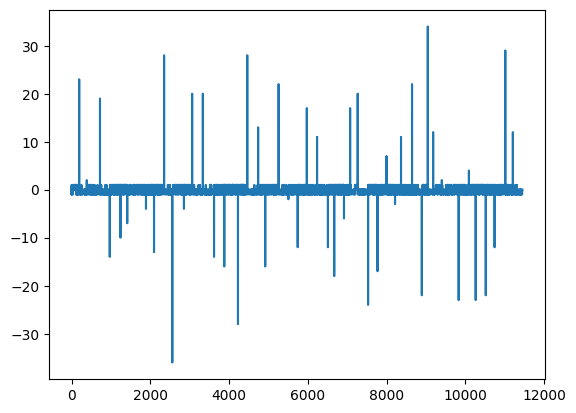

In [ ]:
Persona1 = df['Persona1']
Persona1.plot()

# Preparación de datos para las Redes Neuronales

In [ ]:
df0.shape

(11452, 24)

In [ ]:
def df_to_X_y0(df, window_size=4):
  df_as_np = df.to_numpy()
  X0 = []
  y0 = []
  for step in range(50):
    for i in range(lim[step]-window_size):
      row = [r for r in df_as_np[i:i+window_size]]
      X0.append(row)
      label = df_as_np[i+window_size]
      y0.append(label)
  return np.array(X0), np.array(y0)

In [ ]:
def df_to_X_y1(df, window_size=4):
  df_as_np = df.to_numpy()
  X1 = []
  y1 = []
  for step in range(50):
    for i in range(lim[step]-window_size-1):
      row = [r for r in df_as_np[i:i+window_size]]
      X1.append(row)
      label = df_as_np[i+window_size]
      y1.append(label)
  return np.array(X1), np.array(y1)

In [ ]:
X0, y0 = df_to_X_y0(df0)
X0.shape, y0.shape

((10584, 4, 24), (10584, 24))

In [ ]:
X1, y1 = df_to_X_y1(df)
X1.shape, y1.shape

((10534, 4, 24), (10534, 24))

In [ ]:
X0_train, y0_train = X0[:7500], y0[:7500]
X0_val, y0_val = X0[7500:8500], y0[7500:8500]
X0_test, y0_test = X0[8500:], y0[8500:]
X0_train.shape, y0_train.shape, X0_val.shape, y0_val.shape, X0_test.shape, y0_test.shape

((7500, 4, 24),
 (7500, 24),
 (1000, 4, 24),
 (1000, 24),
 (2084, 4, 24),
 (2084, 24))

In [ ]:
X1_train, y1_train = X1[:7500], y1[:7500]
X1_val, y1_val = X1[7500:8500], y1[7500:8500]
X1_test, y1_test = X1[8500:], y1[8500:]
X1_train.shape, y1_train.shape, X1_val.shape, y1_val.shape, X1_test.shape, y1_test.shape

((7500, 4, 24),
 (7500, 24),
 (1000, 4, 24),
 (1000, 24),
 (2034, 4, 24),
 (2034, 24))

In [ ]:
XX=X1[0]
XX

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0, -1,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  1],
       [-1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0, -1,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0, -1,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  1,  0, -1,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0]])

In [ ]:
X0_train[0]

array([[36, 31,  4,  5, 38, 30, 11, 38, 11, 46, 22, 42, 26, 13, 11,  9,
        26, 14, 23, 17, 20, 40,  6,  5],
       [36, 31,  4,  5, 38, 30, 11, 38, 11, 46, 22, 42, 26, 12, 11,  9,
        26, 14, 23, 17, 20, 40,  7,  5],
       [36, 31,  4,  6, 38, 30, 10, 38, 11, 46, 22, 42, 26, 12, 11,  9,
        26, 14, 23, 17, 19, 40,  8,  5],
       [36, 31,  4,  5, 38, 30, 11, 38, 11, 46, 22, 42, 26, 12, 11,  9,
        26, 14, 23, 17, 19, 40,  8,  5]])

In [ ]:
y0_train[0]

array([36, 31,  4,  6, 38, 29, 11, 38, 11, 46, 22, 42, 26, 12, 11,  9, 26,
       14, 23, 17, 19, 39,  9,  5])

In [ ]:
X1_train[0]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, -1,  0,  1,  0],
       [ 0,  0,  0, -1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, -1,  1,  0]])

In [ ]:
y1_train[0]

array([ 0,  1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  1,  0,  0,
       -1,  0,  0,  0,  0,  0,  0])

# Modelo 2 basado en detección de imágenes con convolución

In [ ]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)
keras.utils.set_random_seed(812)
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=(4,24,1)))
model2.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
model2.add(Conv2D(filters=128, kernel_size=(1,2), activation='relu'))
model2.add(Flatten())
model2.add(Dense(96,activation='relu'))
model2.add(Dense(96,activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(24,activation='linear'))

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 23, 32)         160       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 22, 64)         8256      
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 21, 128)        16512     
                                                                 
 flatten (Flatten)           (None, 5376)              0         
                                                                 
 dense (Dense)               (None, 96)                516192    
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                                 
 dropout (Dropout)           (None, 96)                0

In [ ]:
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model2.fit(X1_train,y1_train,epochs=60, validation_data=(X1_val,y1_val), callbacks=[early_stopping_callback])

Epoch 1/60
235/235 [==============================] - 6s 21ms/step - loss: 0.7975 - root_mean_squared_error: 0.8931 - val_loss: 0.5060 - val_root_mean_squared_error: 0.7113
Epoch 2/60
235/235 [==============================] - 3s 15ms/step - loss: 0.6657 - root_mean_squared_error: 0.8159 - val_loss: 0.3565 - val_root_mean_squared_error: 0.5971
Epoch 3/60
235/235 [==============================] - 3s 14ms/step - loss: 0.3870 - root_mean_squared_error: 0.6221 - val_loss: 0.1563 - val_root_mean_squared_error: 0.3954
Epoch 4/60
235/235 [==============================] - 5s 22ms/step - loss: 0.2461 - root_mean_squared_error: 0.4961 - val_loss: 0.1027 - val_root_mean_squared_error: 0.3205
Epoch 5/60
235/235 [==============================] - 3s 14ms/step - loss: 0.1992 - root_mean_squared_error: 0.4463 - val_loss: 0.0822 - val_root_mean_squared_error: 0.2866
Epoch 6/60
235/235 [==============================] - 3s 14ms/step - loss: 0.1778 - root_mean_squared_error: 0.4217 - val_loss: 0.0668 

#Generación de filas iniciales para usar con el modelo 2

In [ ]:
R=np.random.randint(1, 51, size=12)
R1=np.random.randint(1, 51, size=12)
n_m = tru_mut(R,R1)[1]
nfff=n_m.shape[0]
minitdif = []
for i in range(nfff - 1):
    # Utilizar append para agregar las diferencias a la lista
    minitdif.append(n_m[i + 1] - n_m[i])
n_mm=np.array(minitdif)
matrizini=n_mm[:4, :]

# Inicializar XX como una lista vacía
XX = []

# Iterar sobre las primeras 10 filas de matrizini
for step in range(2):
    # Obtener la fila actual de matrizini
    row = matrizini[step:step+4]

    # Agregar la fila a la lista XX
    XX.append(row)

    # Realizar la predicción con los datos reformateados
    XX_np = np.array(XX).reshape(-1, 4, 24, 1)
    h = model2.predict(XX_np)
    hh = np.round(h)

    # Agregar la fila predicha a matrizini utilizando vstack
    matrizini = np.vstack([matrizini, hh])

    print(matrizini)


1/1 [==============================] - 0s 21ms/step
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  1.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0. -1.  0.  0.  0.  1.]
 [-1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
   0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0. -1.]
 [-0. -0.  0.  0.  0.  0. -0. -0.  0. -0. -0.  0. -0. -0. -0.  0. -0.  0.
  -0. -0. -0.  0. -0.  0.]]
1/1 [==============================] - 0s 24ms/step
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  1.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0. -1.  0.  0.  0.  1.]
 [-1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
   0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.

# Función Plot

In [ ]:
from sklearn.metrics import mean_squared_error as mse

#def plot_predictions1(model, X, y, start=0, end=6000):
#  predictions = model.predict(X).flatten()
#  y=y.flatten()
#  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  #plt.plot(df['Persona1 p'][start:end])
  #plt.plot(df['Persona1 a'][start:end])
  #plt.plot(df['Pressure Predi'][start:end])
 # plt.plot(df['Pressure Actuals'][start:end])
#  return df, mse(predictions, y)


def plot_predictions(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  per1_p, per2_p = predictions[:, 0], predictions[:, 1]
  per1_a, per2_a = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Persona1 predicción': per1_p,
                          'Persona1 actual': per1_a,
                          'Persona2 predicción': per2_p,
                          'Persona2 actual': per2_a
                          })
  plt.plot(df['Persona1 predicción'][start:end])
  plt.plot(df['Persona1 actual'][start:end])
  #plt.plot(df['Persona2 predicción'][start:end])
  #plt.plot(df['Persona2 actual'][start:end])
  return df, mse(predictions[:,0],y[:,0]), mse(predictions[:,1],y[:,1])

# Comparación de Gráficas del modelo 2

64/64 [==============================] - 0s 4ms/step


(      Persona1 predicción  Persona1 actual  Persona2 predicción  \
 0                0.001110                0             0.115210   
 1               -0.076764                0            -0.061113   
 2                0.090955                0            -0.027359   
 3                0.074881                0            -0.042852   
 4               -0.074378                0             0.041582   
 ...                   ...              ...                  ...   
 2029            -0.098179                0             0.064628   
 2030             0.111146                0             0.033962   
 2031             0.057029                0             0.579862   
 2032            -0.056594                0            -0.011491   
 2033            -0.067834                0            -0.041313   
 
       Persona2 actual  
 0                   0  
 1                   0  
 2                   0  
 3                   0  
 4                   0  
 ...               ...  
 2029  

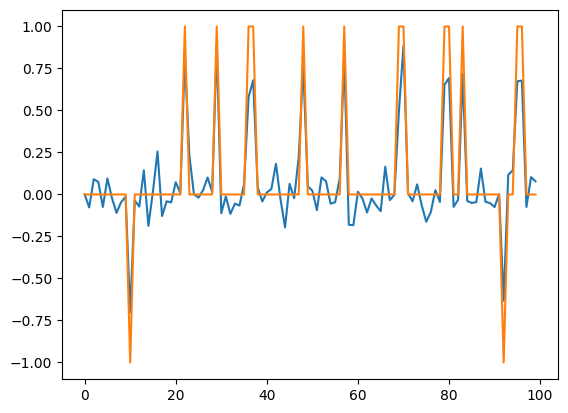

In [ ]:
plot_predictions(model2, X1_test, y1_test)

#Predicción nuevos datos

In [ ]:
R=np.random.randint(1, 51, size=12)
R1=np.random.randint(1, 51, size=12)
n_m = tru_mut(R,R1)[1]
nfff=n_m.shape[0]
minitdif = []
for i in range(nfff - 1):
    # Utilizar append para agregar las diferencias a la lista
    minitdif.append(n_m[i + 1] - n_m[i])
n_mm=np.array(minitdif)
matrizini=n_mm[:4, :]
matrizini

array([[ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,
        -1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,
         0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  1,
        -1,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
XX=np.array([matrizini])
for step in range(30):
  K = np.array([XX[0, step:step+4, :]])
  h = model2.predict(K)
  hh=np.round(h)
  hh = hh.astype(int)
  hh_int = hh[:, np.newaxis, :]
  XX = np.concatenate([XX, hh_int], axis=1)
XX

1/1 [==============================] - 0s 30ms/step


array([[[ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,
         -1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,
          0,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, -1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  1,
         -1,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  0,  0,  0,  0, -1,  0, -1,  0,  0, -1,  0,  1,  0,  0,
          0,  0, -1,  3,  0,  0,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       

In [ ]:
XX=X1_test[:1]
for step in range(10):
  K = np.array([XX[0, step:step+4, :]])
  h = model2.predict(K)
  hh=np.round(h)
  hh = hh.astype(int)
  hh_int = hh[:, np.newaxis, :]
  XX = np.concatenate([XX, hh_int], axis=1)
XX


1/1 [==============================] - 0s 33ms/step


array([[[ 0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  1, -1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,
          0,  0,  1,  0,  0,  0,  0,  0],
        [ 0, -1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1, -1,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  1,  0,  0, -1,  0],
        [ 0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
          0,  1,  0,  0, -1,  0,  0,  0],
        [ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0,  0,  1,  0,
          0,  0,  0, -1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  0,  0,  1, -1,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,
       